<a href="https://colab.research.google.com/github/skolix15/Machine_Learning_2025/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
!pip install xgboost
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler

# Import Data

In [ ]:
train_features = pd.read_csv('train_hh_features.csv')
train_gt = pd.read_csv('train_hh_gt.csv')
test_features = pd.read_csv('test_hh_features.csv')

# Preprocessing

In [ ]:
# Merge training features with ground truth on household ID (hhid)
train_df = pd.merge(train_features, train_gt, on='hhid', how='inner')

In [ ]:
# Drop insignificant/redundant columns
# hhid: unique identifier, com: member id, weight: sampling weight
# survey_ids: redundant identifiers from the merge process
cols_to_drop = ['hhid', 'com', 'survey_id_x', 'survey_id_y', 'weight']
train_df = train_df.drop(columns=[c for c in cols_to_drop if c in train_df.columns])
test_df = test_features.drop(columns=[c for c in cols_to_drop if c in test_features.columns])

In [ ]:
# Define a mapping for binary categorical variables to convert them to numeric (1/0)
binary_map = {
    'Yes': 1, 'No': 0,
    'Access': 1, 'No access': 0,
    'Male': 1, 'Female': 0,
    'Urban': 1, 'Rural': 0
}

In [ ]:
def clean_data(df):

    # Convert simple binary categorical columns using the map
    for col in df.columns:

        if df[col].dtype == 'object':

            unique_vals = set(df[col].dropna().unique())

            if unique_vals.issubset(set(binary_map.keys())):

                df[col] = df[col].map(binary_map)

    # Fill missing values (NaN) with the mean value for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:

        df[col] = df[col].fillna(df[col].mean())

    # Handle remaining categorical columns (multi-level categories)
    # Use factorize to convert strings to integers
    object_cols = df.select_dtypes(include=['object']).columns

    for col in object_cols:

        # Factorize returns codes and unique values; we only need the codes [0]
        # It assigns -1 to null values
        df[col] = pd.factorize(df[col])[0]

        # Replace -1 (previously nulls) with the mean of the column
        df[col] = df[col].replace(-1, df[col].mean())

    return df

# Apply the cleaning function to both train and test sets
train_processed = clean_data(train_df)
test_processed = clean_data(test_df)

# Save the cleaned datasets to new CSV files
train_processed.to_csv('train_processed.csv', index=False)
test_processed.to_csv('test_processed.csv', index=False)

print("Preprocessing complete. Processed files saved as 'train_processed.csv' and 'test_processed.csv'.")

Preprocessing complete. Processed files saved as 'train_processed.csv' and 'test_processed.csv'.


# Machine Learning model Training

Three algorithms are going to be used:

1.   Ridge Regression
2.   Random Forest
3.   XGBoost



In [ ]:
train_df = pd.read_csv('train_processed.csv')
X = train_df.drop(columns=['cons_ppp17'])
y = train_df['cons_ppp17']

In [ ]:
# Split into Train and Validation sets (80-20)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Dictionary to store performance
results = {}

In [ ]:
# --- Model 1: Ridge Regression (Linear model with L2 regularization) ---
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_val)
results['Ridge'] = {'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_ridge)), 'R2': r2_score(y_val, y_pred_ridge)}

In [ ]:
# --- Model 2: Random Forest (Ensemble Learning) ---
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
results['RandomForest'] = {'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_rf)), 'R2': r2_score(y_val, y_pred_rf)}

In [ ]:
# --- Model 3: XGBoost (Gradient Boosting) ---
xgb_model = xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_val)
results['XGBoost'] = {'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_xgb)), 'R2': r2_score(y_val, y_pred_xgb)}

In [ ]:
# Print Comparison Table
res_df = pd.DataFrame(results).T
print("Model Comparison on Validation Set:")
print(res_df)

Model Comparison on Validation Set:
                  RMSE        R2
Ridge         7.064947  0.503202
RandomForest  6.261639  0.609754
XGBoost       5.819342  0.662938


# Deep Learning model Training

In [ ]:
# Scaling (crucial for Neural Networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# Define the architecture
nn_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2), # Regularization to avoid overfitting
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # Linear output for regression
])

nn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
history = nn_model.fit(
  X_train_scaled,
  y_train,
  validation_data=(X_val_scaled, y_val),
  epochs=20,
  batch_size=64,
  verbose=1
)

Epoch 1/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 55.5677 - mae: 4.3388 - val_loss: 38.1528 - val_mae: 3.4229
Epoch 2/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 42.2179 - mae: 3.5818 - val_loss: 38.0674 - val_mae: 3.3866
Epoch 3/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 38.5799 - mae: 3.4862 - val_loss: 37.2181 - val_mae: 3.4517
Epoch 4/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 38.2836 - mae: 3.4628 - val_loss: 36.1298 - val_mae: 3.3630
Epoch 5/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 35.5362 - mae: 3.4068 - val_loss: 35.8818 - val_mae: 3.3950
Epoch 6/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 39.7186 - mae: 3.4446 - val_loss: 36.9993 - val_mae: 3.3080
Epoch 7/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 36.3143 - mae: 3.3800 - val_loss: 35.8267 - val_mae: 3.2924
Epoch 8/20
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 38.4388 - mae: 3.4476 - val_loss: 35.4287 - val_mae: 3.3211
Epoch 9/20
1303/1303 ━

In [ ]:
# Evaluate
y_pred_nn = nn_model.predict(X_val_scaled).flatten()
results['NeuralNetwork'] = {'RMSE': np.sqrt(mean_squared_error(y_val, y_pred_nn)), 'R2': r2_score(y_val, y_pred_nn)}

652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


# Compare and Graphs

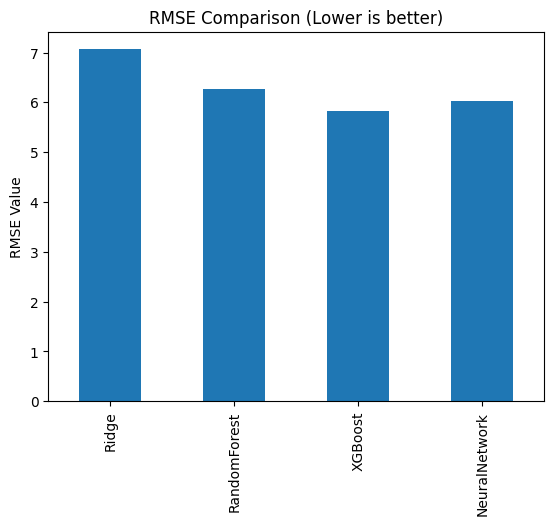

In [ ]:
# 1. Plot Model Comparison
res_df = pd.DataFrame(results).T
res_df['RMSE'].plot(kind='bar', title='RMSE Comparison (Lower is better)')
plt.ylabel('RMSE Value')
plt.show()

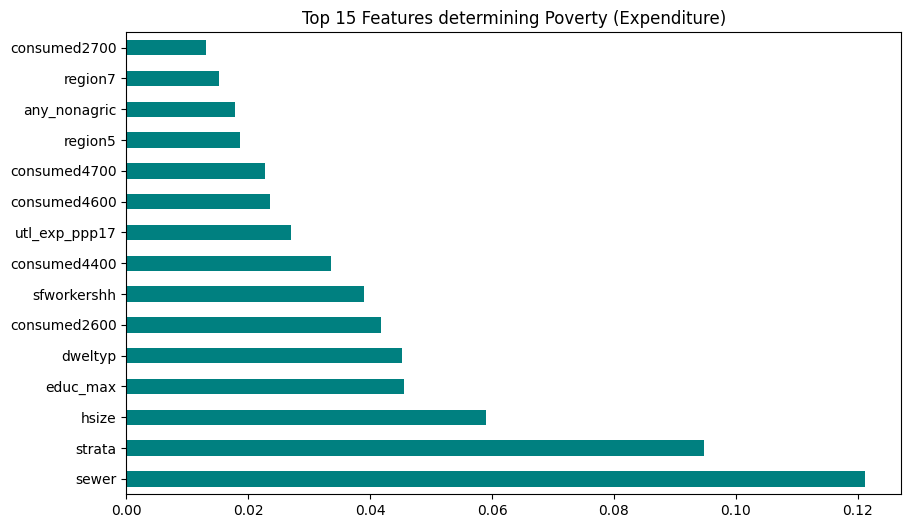

In [ ]:
# 2. Plot Feature Importance (from XGBoost)
plt.figure(figsize=(10,6))
feat_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh', color='teal')
plt.title("Top 15 Features determining Poverty (Expenditure)")
plt.show()

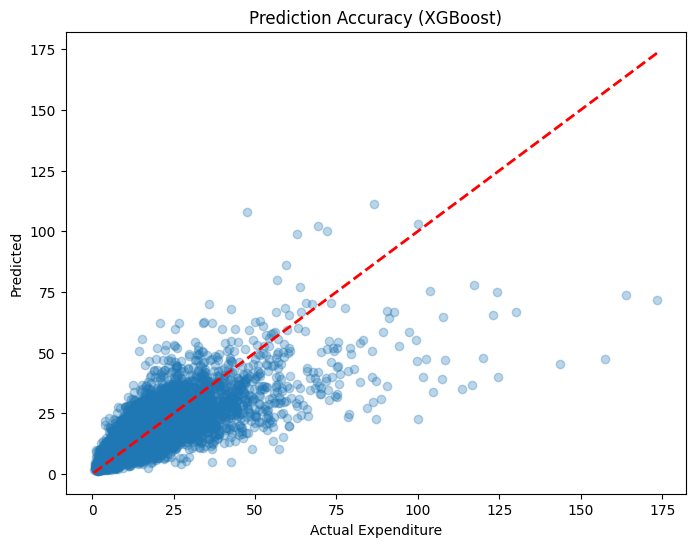

In [ ]:
# 3. Actual vs Predicted (Best Model)
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_xgb, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], '--r', linewidth=2)
plt.xlabel('Actual Expenditure')
plt.ylabel('Predicted')
plt.title('Prediction Accuracy (XGBoost)')
plt.show()

# Create submission

In [ ]:
import pandas as pd
import numpy as np
import zipfile

# Load the processed test features and original test data for IDs
test_processed = pd.read_csv('test_processed.csv')
test_original = pd.read_csv('test_hh_features.csv')

# Synchronize columns with the training set
# We must ensure test_processed has only the columns used during training (X.columns)
# and they must be in the exact same order.
if 'survey_id' in test_processed.columns:
    test_processed = test_processed.drop(columns=['survey_id'])

# This ensures the features match the model's expected input
test_processed = test_processed[X.columns]

# Generate predictions using your best trained model (e.g., xgb_model)
final_preds = xgb_model.predict(test_processed)

# Create the first required CSV: 'predicted_household_consumption.csv'
# The headers must be exactly: survey_id, hhid, cons_ppp17
consumption_df = pd.DataFrame({
    'survey_id': test_original['survey_id'],
    'hhid': test_original['hhid'],
    'cons_ppp17': final_preds
})

# Save the first file
consumption_df.to_csv('predicted_household_consumption.csv', index=False)

# Create the second required CSV: 'predicted_poverty_distribution.csv'
# We calculate the poverty rates for each survey based on the provided thresholds
thresholds = [3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70, 8.40, 9.13,
              9.87, 10.70, 11.62, 12.69, 14.03, 15.64, 17.76, 20.99, 27.37]

poverty_dist_results = []

# Group the household predictions by survey_id to calculate statistics per survey
for s_id, group in consumption_df.groupby('survey_id'):
    row = {'survey_id': s_id}
    for t in thresholds:
        # Calculate what percentage of households are below each threshold
        rate = (group['cons_ppp17'] < t).mean()
        row[f'pct_hh_below_{t:.2f}'] = rate
    poverty_dist_results.append(row)

poverty_df = pd.DataFrame(poverty_dist_results)

# Save the second file
poverty_df.to_csv('predicted_poverty_distribution.csv', index=False)

# Create the final 'submission.zip' file containing both CSVs at the root level
with zipfile.ZipFile('submission.zip', 'w') as z:
    z.write('predicted_household_consumption.csv')
    z.write('predicted_poverty_distribution.csv')

print("Submission files generated successfully!")
print("- Created: predicted_household_consumption.csv")
print("- Created: predicted_poverty_distribution.csv")
print("- Created: submission.zip (Ready for Upload)")

Submission files generated successfully!
- Created: predicted_household_consumption.csv
- Created: predicted_poverty_distribution.csv
- Created: submission.zip (Ready for Upload)
